In [1]:
from gensim import models
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras import layers

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from keras.utils import np_utils
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
def get_kmers(sequences, kmer=4):
    return_seqs = sequences.copy()
    # if kmer <= 1:
    #     raise ValueError("kmer size must be greater than 1")
    for seq_index, seq in sequences.iteritems():
        kmer_list = []
        enum = seq[:-kmer + 1] if kmer > 1 else seq
        for let_index, let in enumerate(enum):
            kmer_list.append(seq[let_index:let_index + kmer])
        return_seqs[seq_index] = kmer_list
    return return_seqs

def get_2d_kmer(seqs, mnm, mxm):
    return_seqs = []
    for _, val in seqs.iteritems():
        kmer_seqs = []
        for i in range(mnm, mxm+1):
            kmers = list(get_kmers(pd.Series([val]), kmer=i))[0]
            # kmers += [kmers[-1] for _ in range(i-1)]
            kmer_seqs.append(kmers)
        return_seqs.append(kmer_seqs)
    
    return pd.Series(return_seqs)

def dup_vecs(dfs):
    dup_X_2d = []
    for df_ind, df in enumerate(dfs):
        num_dupes = 4**(2-df_ind)
        print(num_dupes)
        new_df = df.values.tolist()
        for ind, seq in enumerate(new_df):
            new_seq = []
            for num in seq:
                for i in range(num_dupes):
                    new_seq.append(num)
            new_df[ind] = new_seq
        dup_X_2d.append(pd.DataFrame(new_df))

    return dup_X_2d

def vectorize_1d(X, kmer, model):
    X = get_kmers(kmer)
    df_list = []
    for _, seq in X.iteritems():
        seq_matrix = [model.wv[val] for val in seq]
        df_list.append(seq_matrix)
    df_list = np.array(df_list)
    df_list = df_list.reshape(*df_list.shape, 1).astype('float32')
    return df_list


def vectorize_2d(X, mnm, mxm, model):

    X = get_2d_kmer(X, mnm, mxm)

    for _, seq in X.iteritems():
        for mer in seq[:-1]:
            del mer[-(mxm-len(mer[0])):]

    df_list = np.zeros(shape=(6764,mxm-mnm+1,len(X[0][0]),100))
    for i, seq in X.iteritems():
        seq_matrix = []
        for mer in seq:
            mer_matrix = []
            for val in mer:
                # print(val)
                mer_matrix.append(model.wv[val])
            seq_matrix.append(mer_matrix)
            # print(np.array(seq_matrix).shape)
        df_list[i] = seq_matrix
    df_list = df_list.reshape(*df_list.shape, 1).astype('float32')
    return df_list

opt = keras.optimizers.Adam(learning_rate=0.0005)

def cnn2d(input_shape, num_classes):
    model = keras.Sequential()
    model.add(layers.Dropout(0.1, input_shape=input_shape))
    model.add(layers.Conv2D(32,77, input_shape=input_shape))
    model.add(layers.Activation(activation='softsign'))
    model.add(layers.Dropout(0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(16))
    model.add(layers.Activation(activation='softsign'))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation(activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def cnn3d(input_shape, num_classes):
    model = keras.Sequential()
    model.add(layers.Dropout(0.1, input_shape=input_shape))
    model.add(layers.Conv3D(32,(input_shape[0]-1, input_shape[1]-1, input_shape[1]-1), input_shape=input_shape))
    model.add(layers.Activation(activation='softsign'))
    model.add(layers.Dropout(0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(16))
    model.add(layers.Activation(activation='softsign'))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation(activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
data = pd.read_csv('../data/pro_nonpro.csv')
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
X = data.Seq
y = data.Level

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

In [5]:
X_2d = get_2d_kmer(X, mnm=1, mxm=10)

In [6]:
# for _, seq in X_2d.iteritems():
#     for mer in seq[:-1]:
#         del mer[-(10-len(mer[0])):]

In [6]:
sents = [i for _, v in X_2d.iteritems() for i in v]

In [7]:
word2vec_model = models.Word2Vec(
    sentences=sents,
    min_count=1,
    window=10,
    workers=4
    )

word2vec_model.save('word2vecmodel')

In [6]:
model = models.word2vec.Word2Vec.load('./word2vecmodel')

In [24]:
inpt_data = vectorize_2d(X, 1, 10, model)

In [10]:
inpt_data.shape

(6764, 3, 76, 100, 1)

In [11]:
num_features = 100
num_classes = 2
num_epochs = 150
input_shape = inpt_data.shape[1:]

In [12]:
y

0       0
1       1
2       1
3       1
4       1
       ..
6759    0
6760    1
6761    0
6762    0
6763    0
Length: 6764, dtype: int64

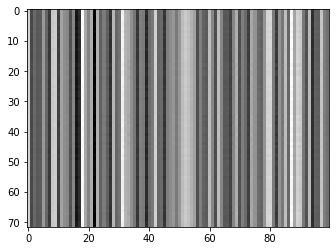

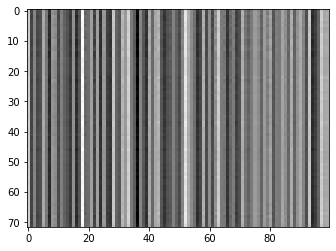

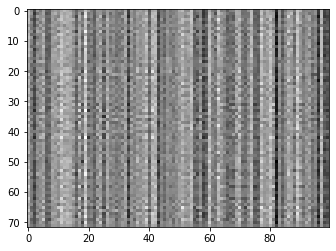

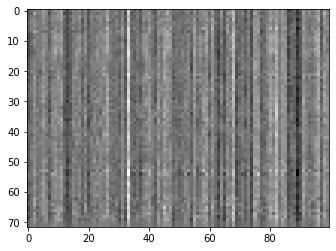

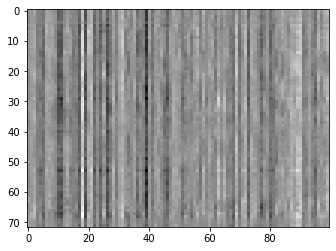

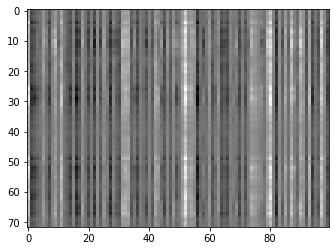

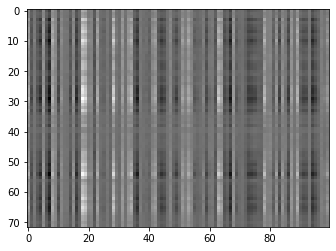

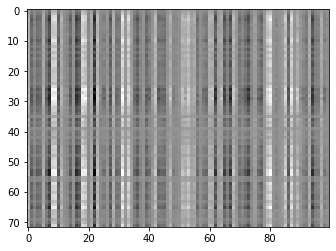

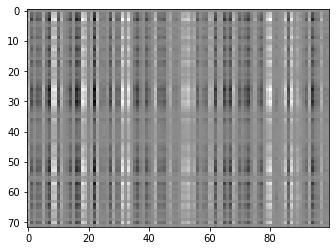

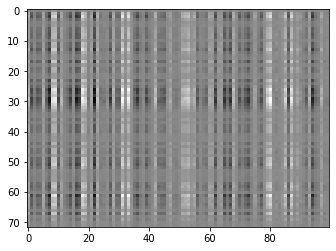

In [29]:
for i in range(10):
    plt.imshow(inpt_data[0][i], cmap='gray')
    plt.show()


In [14]:
X_train, X_test, y_train, y_test = tts(inpt_data, y, train_size=0.8)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test_keras = np_utils.to_categorical(y_test, num_classes)

In [15]:
# for train, test in kfold.split(X, y):

cnn = cnn3d(input_shape, num_classes)

history = cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test_keras),
    epochs=num_epochs,
    batch_size=128,
    verbose=True,
)


Epoch 1/150
43/43 [==============================] - 5s 56ms/step - loss: 0.6765 - accuracy: 0.6879 - val_loss: 0.5492 - val_accuracy: 0.8204
Epoch 2/150
43/43 [==============================] - 2s 51ms/step - loss: 0.5103 - accuracy: 0.8082 - val_loss: 0.4616 - val_accuracy: 0.8071
Epoch 3/150
43/43 [==============================] - 3s 62ms/step - loss: 0.4361 - accuracy: 0.8191 - val_loss: 0.5249 - val_accuracy: 0.7258
Epoch 4/150
43/43 [==============================] - 3s 68ms/step - loss: 0.4503 - accuracy: 0.8035 - val_loss: 0.4571 - val_accuracy: 0.7879
Epoch 5/150
43/43 [==============================] - 3s 70ms/step - loss: 0.4276 - accuracy: 0.8222 - val_loss: 0.4499 - val_accuracy: 0.8056
Epoch 6/150
43/43 [==============================] - 3s 71ms/step - loss: 0.4123 - accuracy: 0.8268 - val_loss: 0.3995 - val_accuracy: 0.8300
Epoch 7/150
43/43 [==============================] - 3s 72ms/step - loss: 0.4208 - accuracy: 0.8248 - val_loss: 0.3905 - val_accuracy: 0.8359
Epoch 

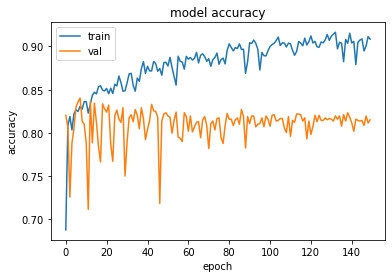

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
max(history.history['val_accuracy'])

0.8403547406196594

43/43 [==============================] - 0s 4ms/step
CV: 


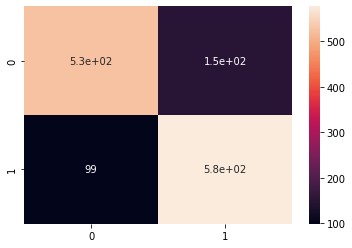

In [18]:
predictions = cnn.predict(
    X_test)
predictions = np.argmax(predictions, axis=1)
true_labels = np.asarray(y_test)
print('CV: ')
sns.heatmap(pd.DataFrame(confusion_matrix(true_labels, predictions), range(num_classes), range(num_classes)), annot=True)
plt.show()


In [19]:
X_test.shape

(1353, 3, 76, 100, 1)

In [20]:
test_data = pd.read_csv('../data/pro_nonpro.csv')
test = test_data.Seq
test_val = test_data.Level
inpt = vectorize_2d(test, 4, 6, model)
pred = cnn.predict(inpt)
preds = [list(i).index(max(i)) for i in pred]

212/212 [==============================] - 1s 4ms/step


In [21]:
pred.shape

(6764, 2)

In [22]:
list(preds == test_val).count(True) / 6764

0.9151389710230633

In [23]:
preds==test_val

0        True
1        True
2       False
3       False
4        True
        ...  
6759    False
6760    False
6761     True
6762     True
6763     True
Name: Level, Length: 6764, dtype: bool